## Visualizing Lake Breeze Location and Analyzing Occurrence for a Pneumonia Front over Chicago


This notebook demonstrates how to use the ADAM library to infer the location of the lake breeze over Chicago. As a case study, we examine the pneumonia front event that occurred on April 24, 2025.


In [1]:
import adam
import pyart
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.optimize import minimize
from scipy.ndimage import center_of_mass, label


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



To begin, we preprocess the radar data to extract the reflectivity fields needed for lake breeze detection. The ADAM library simplifies this by converting radar reflectivity fields into ImageNet-compatible images, which can be used directly with inference models. For batch processing of multiple NEXRAD files, use `adam.io.preprocess_radar_image_batch`; for single images, use `adam.io.preprocess_radar_image`.

By default, `adam.io.preprocess_radar_image_batch` uses Dask to process files in parallel. To run the processing serially, set the `parallel` keyword argument to `False`.

In [2]:
rad_scan1 = adam.io.preprocess_radar_image_batch('/Users/rjackson/klot_batch_test/*_*V06', parallel=True)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

Process SpawnProcess-6:
Process SpawnProcess-5:
Process SpawnProcess-3:
Process SpawnProcess-4:
Process SpawnProcess-2:
Process SpawnProcess-7:
Process SpawnProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/rjackson/mambaforge/envs/torch_env/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Users/rjackson/mambaforge/envs/torch_env/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rjackson/mambaforge/envs/torch_env/lib/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/rjackson/mambaforge/envs/torch_env/lib/python3.13/multiprocessing/queues.py", line 100,

KeyboardInterrupt: 

To process a single radar image, use `adam.io.preprocess_radar_image`. This function takes a 4-letter NEXRAD radar identifier as the first argument and an ISO-format UTC time as the second argument. Alternatively, you can provide a Py-ART radar object directly. This flexibility makes it easy to preprocess individual radar scans for further analysis.

In [3]:
rad_scan = adam.io.preprocess_radar_image('KLOT', '2025-04-24T19:42:38')
rad_scan.pyart_object.time

{'units': 'seconds since 2025-04-24T19:42:38Z',
 'standard_name': 'time',
 'long_name': 'time_in_seconds_since_volume_start',
 'calendar': 'gregorian',
 'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
 'data': array([  0.521,   0.626,   0.729, ..., 405.282, 405.338, 405.394],
       shape=(6480,))}

Next, we use `adam.model.infer_lake_breeze_batch` to perform batch inference on the preprocessed data. For inference on a single time period, you can use `adam.model.infer_lake_breeze`.

In [4]:
rad_scan = adam.model.infer_lake_breeze(
    rad_scan, model_name='lakebreeze_model_fcn_resnet50_no_augmentation')

To visualize the results of lake breeze detection, use the `adam.vis.visualize_lake_breeze` function. This tool overlays detected lake breeze segments directly onto the radar imagery, providing a clear and intuitive view of the phenomenon. In the example below, we focus on the event observed at 19:42 UTC on April 24, 2025, to see exactly where the lake breeze was identified during this time.

(<Figure size 500x500 with 2 Axes>,
 <GeoAxes: title={'center': 'KLOT 0.5 Deg. 2025-04-24T19:42:38Z \nEquivalent reflectivity factor'}>)

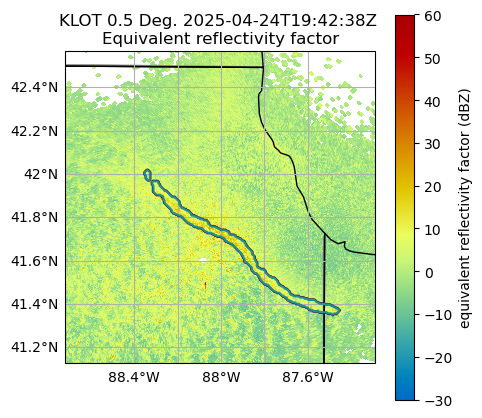

In [5]:
adam.vis.visualize_lake_breeze(rad_scan, vmin=-30, 
                               vmax=60, cmap='HomeyerRainbow')

Let's set up an instrument at the Argonne Testbed for Mulltiscale Observational Science (ATMOS). ATMOS os located at 41.70101404798476, -87.99577278662817 in Lemont, IL

129.10918125067565
-87.92111921568628 41.64752941176471
-87.92111921568628 41.64752941176471


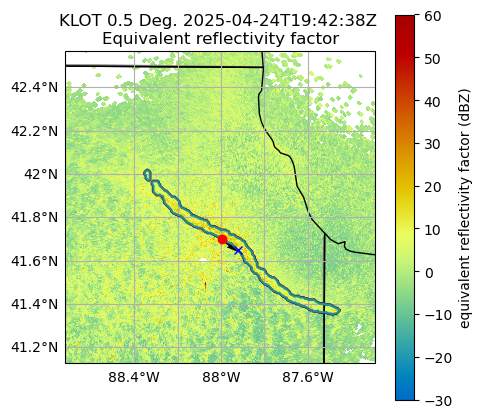

In [12]:
angle, lat, lon = adam.util.azimuth_point(-87.99577278662817, 41.70101404798476, rad_scan)
print(angle)
fig, ax = adam.vis.visualize_lake_breeze(rad_scan, vmin=-30, 
                                        vmax=60, cmap='HomeyerRainbow')
ax.plot(-87.99577278662817, 41.70101404798476, 'ro', transform=ccrs.PlateCarree())
ax.quiver(-87.99577278662817, 41.70101404798476, 
          np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle)), 
          transform=ccrs.PlateCarree(), color='k', scale=15)
ax.plot(lon, lat, 'bx', transform=ccrs.PlateCarree())
print(lon, lat)

## Plotting a Density Map of Lake Breeze Occurrence over Chicago for the Day

To analyze how the lake breeze location evolves throughout the day, we can generate density plots and perform statistical analyses. The `RadarImage` class provides several useful properties for this purpose:

- `grid_lat`: Latitude of each grid point
- `grid_lon`: Longitude of each grid point
- `grid_x`: Easting (meters) relative to the radar
- `grid_y`: Northing (meters) relative to the radar
- `lakebreeze_mask`: Numpy array containing lake breeze identification

The `RadarImage` object supports slicing and indexing by integer, string, or `np.datetime64` to access the lake breeze mask. This makes it easy to analyze the mask over time or across scans.

The following code retrieves the sum of all lake breeze occurrences over a specified time interval.

In [10]:
rad_scan.aggregate('2024-05-25T23:10:00', 
                   '2024-05-25T23:59:00')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(256, 256))

You can also use integer or time slice indexing to extract arrays from specific radar scans for further analysis.

In [11]:
rad_scan[0:1]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 256, 256))

(41.0, 43.0)

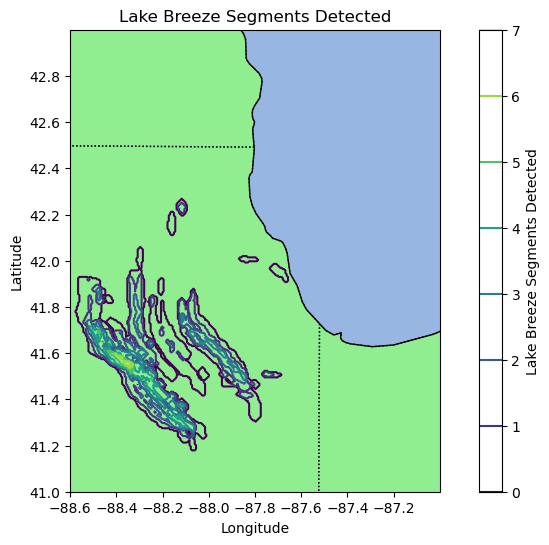

In [15]:
# Get the total number of lake breeze segments detected

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
plt.contour(rad_scan.grid_lon, rad_scan.grid_lat, rad_scan[:].sum(axis=0).T)
plt.colorbar(label='Lake Breeze Segments Detected')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='lightgreen')
ax.set_title('Lake Breeze Segments Detected on 25 May 2024')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks(np.arange(-88.6, -87, 0.2),
               crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(41, 43, 0.2),
               crs=ccrs.PlateCarree())
ax.set_xlim([-88.6, -87])
ax.set_ylim([41, 43])